In [273]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings

from scipy.stats import zscore
from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
# Display up to 500 columns of a wide dataframe, instead of ...-ing them 
pd.set_option('display.max_columns', 500)

# Functions

In [274]:
# Pass in a dataframe, a list of columns to interpolate, and the limit direction.
# Loop through all of the columns and interpolate.
# Return the updated dataframe.
def interpolate_missing(df,key_column,column_list,limit_dir):
    for each_value in df[key_column].unique():
        for column in column_list:
            mask = (df[key_column] == each_value)
            df.loc[mask, column] = df.loc[mask, column].interpolate(limit_direction=limit_dir)
    return df

In [275]:
# Show us how many outliers there are, given a threshold of standard deviations 1-5.
# Prints the indices of the outliers.
# Doesn't return anything.
def calculate_zscore(series):
    z_scores = zscore(series)
    for threshold in range(1,5):
        print("The score threshold is: {}".format(threshold))
        print("The indices of the outliers:")
        print(np.where(z_scores > threshold))
        print("Number of outliers is: {}".format(len((np.where(z_scores > threshold)[0]))))    

In [276]:
def tukeys_method(series):
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.
    q75, q25 = np.percentile(series, [75 ,25])
    iqr = q75 - q25

    for threshold in np.arange(1,5,0.5):
        min_val = q25 - (iqr*threshold)
        max_val = q75 + (iqr*threshold)
        print("The score threshold is: {}".format(threshold))
        print("Number of outliers is: {}".format(
            len((np.where((series > max_val) 
                          | (series < min_val))[0]))
        ))

In [277]:
def basic_boxplot(series, plot_title):
    fig, ax = plt.subplots(figsize=(15,5))
    boxplot = plt.boxplot(series,vert=False)
    ax.set_yticklabels([])
    title = plt.title(plot_title)

# Assignment
In this assignment, you'll continue working with the U.S. Education Dataset from Kaggle. The data gives detailed state level information on several facets of education on an annual basis. To learn more about the data and the column descriptions, you can view the Kaggle link.

Don't forget to apply the most suitable missing value filling techniques from the previous checkpoint to the data. Provide the answers to the following only after you've addressed missing values!

Access this data using the Thinkful database using these credentials:

In [278]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

In [279]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# I connected via pgAdmin4 and verified the table name is the same as the db name
used_df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

#### Determine all the variable types and find the fraction of the missing values for each variable.

PRIMARY_KEY, STATE are the only two non-numeric fields.

State is categorical, nominal data--mostly the full names of a state, district, or US territory. There are a few outlying values that are 2-3 character abbreviations, and a few variations containing "DOD" we can probably combine, if we don't want to drop these rows altogether.

YEAR is technically continuous, interval, but its use here is probably more categorical, ordinal--we're not using year to _measure_ a length of time, but sorting by the YEAR column allows us to compare scores year over year.

PRIMARY_KEY is a combination of 4-digit year and state|district|territory. I think having the year as a part of this key makes it categorical, ordinal, for the same reasons that YEAR alone is categorical, ordinal.

Revenues and expenditures are dollar amounts. These values are continuous, ratio.

ENROLL and GRADES_* are the numbers of students in each grade, or in a range of grades (this comes directly from [the Kaggle page](https://www.kaggle.com/noriuk/us-education-datasets-unification-project/home)). These fields are continuous, ratio.

The AVG_* scores represent a state's average score for fourth or eighth graders taking an NAEP exam in reading or math. I found some information about interpreting NAEP scores [here](https://nces.ed.gov/nationsreportcard/mathematics/interpret_results.aspx). These values are continuous, interval--there is a "zero" within the possible range of values, but the ranges are not the same between grades, and it's not clear that an average score of, say, 300 means those students know exactly twice as much about reading or math as a group of students with an average of 150.

In [280]:
used_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [281]:
# There are a lot of entries from US territories that are mostly NaNs and
# which don't have the full complement of data the states have--
# the only populated columns in most of these rows are for GRADES_*.
# These rows aren't particularly useful otherwise, so let's just drop them.
state_counts = used_df['STATE'].value_counts()

# A full complement of data for a state is 26 rows/years.
to_remove = state_counts[state_counts < 26].index

# Keep rows in the df where the state is not on the list to_remove
used_df = used_df[~used_df['STATE'].isin(to_remove)]

In [282]:
# We can get the percentage of null values per column like this:
# The sum of null rows for each column * 100, divided by the total number of rows for each column:
used_df.isnull().sum()*100/used_df.isnull().count()

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                           7.663411
TOTAL_REVENUE                    3.831705
FEDERAL_REVENUE                  3.831705
STATE_REVENUE                    3.831705
LOCAL_REVENUE                    3.831705
TOTAL_EXPENDITURE                3.831705
INSTRUCTION_EXPENDITURE          3.831705
SUPPORT_SERVICES_EXPENDITURE     3.831705
OTHER_EXPENDITURE                7.663411
CAPITAL_OUTLAY_EXPENDITURE       3.831705
GRADES_PK_G                      8.489857
GRADES_KG_G                      7.663411
GRADES_4_G                       7.663411
GRADES_8_G                       7.663411
GRADES_12_G                      7.663411
GRADES_1_8_G                     7.663411
GRADES_9_12_G                    7.663411
GRADES_ALL_G                     8.489857
AVG_MATH_4_SCORE                59.729527
AVG_MATH_8_SCORE                60.030053
AVG_READING_4_SCORE             59

So I originally suggested calculating means for the nearest 2-5 years for most of these columns. Now that I actually have to do the work, I'm just using the .interpolate() method to fill in NaNs. :)

Some spot checks make me believe this is a reasonable approach--even in the AVG columns, where there is only fresh data every few years, .interpolate() fills in with values that fall between those for populated years in a linear fashion. This should maintain reasonable measures of central tendency.


>* ENROLL - Calculate the mean of the surrounding populated years. If the first/last values within the range of years are not populated, either use the next or last available value, or calculate a mean based on the nearest 2-5 populated years. The first/last issue seems to be a consistent one across all of the states I spot checked.
>
>* REVENUE columns - Where these columns are all NaN, calculate the mean for each column for, say, the previous 2-5 years. This way we're still using numbers that are relatively close in time, measured in dollars whose value has not been changed significantly by inflation (probably NOT true when comparing early 1990s dollars to late 2010s).
>
>* EXPENDITURE columns - We can treat these expenditure columns the same way as the revenue columns, including rows where just OTHER_EXPENDITURE isn't populated.
>
>* GRADES columns - These columns can also be treated like the revenue columns if they're not populated. I see the two most recent years are the ones that are not populated, which means we're probably using the same interpolated mean for both?
>
>* AVG_* - The population pattern of the AVG columns implies that the NAEP tests aren't administered every year, or that data is only collected for them periodically. I also see some cases where not all 4 averages are available for a given year.
>
>    Between years where a set of values is available, I'd either carry the previous values forward, or calculate the mean of the previous and next new values. For instance, for 1993-1995, we could carry forward values from 1992, or get the mean of the 1992 and 1996 average scores, and use that.

In [283]:
used_df = interpolate_missing(used_df,
                                     'STATE',
                                     ['AVG_MATH_4_SCORE',
                                      'AVG_MATH_8_SCORE',
                                      'AVG_READING_4_SCORE',
                                      'AVG_READING_8_SCORE',
                                      'GRADES_PK_G',
                                      'GRADES_KG_G',
                                      'GRADES_4_G',
                                      'GRADES_8_G',
                                      'GRADES_12_G',
                                      'GRADES_1_8_G',
                                      'GRADES_9_12_G',
                                      'GRADES_ALL_G'
                                     ],                                     
                                     'both')

In [284]:
# The sum of null rows for each column * 100, divided by the total number of rows for each column:
used_df.isnull().sum()*100/used_df.isnull().count()

PRIMARY_KEY                     0.000000
STATE                           0.000000
YEAR                            0.000000
ENROLL                          7.663411
TOTAL_REVENUE                   3.831705
FEDERAL_REVENUE                 3.831705
STATE_REVENUE                   3.831705
LOCAL_REVENUE                   3.831705
TOTAL_EXPENDITURE               3.831705
INSTRUCTION_EXPENDITURE         3.831705
SUPPORT_SERVICES_EXPENDITURE    3.831705
OTHER_EXPENDITURE               7.663411
CAPITAL_OUTLAY_EXPENDITURE      3.831705
GRADES_PK_G                     0.000000
GRADES_KG_G                     0.000000
GRADES_4_G                      0.000000
GRADES_8_G                      0.000000
GRADES_12_G                     0.000000
GRADES_1_8_G                    0.000000
GRADES_9_12_G                   0.000000
GRADES_ALL_G                    0.000000
AVG_MATH_4_SCORE                0.000000
AVG_MATH_8_SCORE                0.000000
AVG_READING_4_SCORE             0.000000
AVG_READING_8_SC

In [285]:
# Except for AVG scores, rows with a year == 2017 have all NaNs in other columns.
# We've interpolated the AVG columns and so have made use of the 2017 rows
# where those columns are populated, so let's drop 2017 now.
used_df = used_df[used_df['YEAR'] != 2017]

Spot check--how do things look?

In [286]:
used_df.loc[used_df['STATE'] == 'MINNESOTA']

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE,GRADES_PK_G,GRADES_KG_G,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
23,1992_MINNESOTA,MINNESOTA,1992,NaN,4684684.0,194092.0,2380754.0,2109838.0,4981125.0,2534882.0,1343203.0,NaN,463724.0,6394.0,61966.0,62606.0,59810.0,53813.0,500938.0,224426.0,731758.0,228.493596,282.392205,218.301709,264.888121
76,1993_MINNESOTA,MINNESOTA,1993,781566.0,4862635.0,213724.0,2284106.0,2364805.0,5290504.0,2756415.0,1327959.0,466306.0,512196.0,6656.0,62345.0,63194.0,63105.0,54642.0,507979.0,233253.0,747888.0,229.418469,282.806390,219.183810,264.888121
128,1994_MINNESOTA,MINNESOTA,1994,802913.0,5262482.0,224106.0,2822949.0,2215427.0,5581140.0,2876527.0,1388180.0,490949.0,565106.0,8060.0,62908.0,64605.0,64607.0,55982.0,510458.0,240267.0,758785.0,230.343342,283.220575,220.065912,264.888121
180,1995_MINNESOTA,MINNESOTA,1995,816695.0,5744447.0,235069.0,2919940.0,2589438.0,6155324.0,3109813.0,1526879.0,523268.0,662497.0,8340.0,63896.0,64545.0,65649.0,57793.0,513844.0,249086.0,771270.0,231.268215,283.634760,220.948013,264.888121
232,1996_MINNESOTA,MINNESOTA,1996,827418.0,6101416.0,241241.0,3435468.0,2424707.0,6423285.0,3204906.0,1522656.0,551475.0,762106.0,8902.0,62383.0,63024.0,65881.0,60413.0,517467.0,258452.0,784821.0,232.193088,284.048945,221.830114,264.888121
283,1997_MINNESOTA,MINNESOTA,1997,837847.0,6304977.0,251210.0,3321859.0,2731908.0,6890773.0,3461407.0,1641569.0,585789.0,799154.0,8945.0,62126.0,63494.0,66529.0,63727.0,516654.0,265896.0,791495.0,232.962538,284.949694,222.687214,264.888121
335,1998_MINNESOTA,MINNESOTA,1998,841723.0,6672384.0,313550.0,3363505.0,2995329.0,6815289.0,3384437.0,1721705.0,452482.0,781250.0,9116.0,61023.0,64101.0,67899.0,63014.0,516580.0,269736.0,795432.0,233.731988,285.850443,223.544314,264.888121
387,1999_MINNESOTA,MINNESOTA,1999,843802.0,6949149.0,322148.0,3873937.0,2753064.0,7450965.0,3622534.0,1855510.0,497073.0,965469.0,9234.0,58952.0,64934.0,67705.0,67044.0,512177.0,273671.0,795082.0,234.501438,286.751193,224.401414,264.888121
439,2000_MINNESOTA,MINNESOTA,2000,839839.0,7344747.0,330914.0,4265438.0,2748395.0,7736391.0,3825732.0,1942294.0,531329.0,901829.0,9300.0,58963.0,63334.0,66254.0,67573.0,509503.0,276574.0,795377.0,235.270888,287.651942,225.258514,264.888121
492,2001_MINNESOTA,MINNESOTA,2001,836386.0,7836617.0,350797.0,4694722.0,2791098.0,8221636.0,3981906.0,2112589.0,569072.0,964810.0,9671.0,58357.0,62580.0,66797.0,68997.0,505000.0,278356.0,793027.0,237.484690,288.661313,224.375330,265.760358


## 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

Yes:

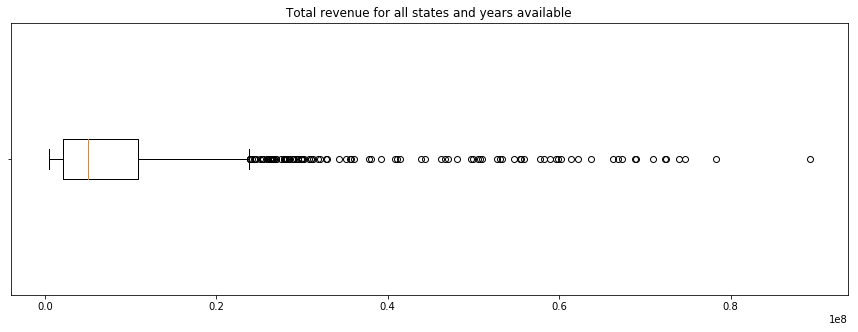

In [287]:
basic_boxplot(used_df['TOTAL_REVENUE'],"Total revenue for all states and years available")

In [288]:
calculate_zscore(used_df['TOTAL_REVENUE'])

The score threshold is: 1
The indices of the outliers:
(array([   4,   32,   56,   85,  108,  137,  150,  161,  190,  213,  241,
        252,  264,  292,  304,  316,  344,  355,  367,  395,  406,  419,
        448,  459,  471,  480,  500,  511,  523,  551,  563,  575,  603,
        614,  626,  631,  635,  652,  654,  660,  666,  678,  683,  687,
        704,  706,  712,  717,  729,  735,  739,  756,  758,  761,  764,
        769,  782,  787,  791,  809,  811,  814,  817,  822,  834,  840,
        844,  861,  863,  866,  869,  874,  889,  895,  899,  916,  918,
        921,  924,  929,  941,  947,  951,  968,  970,  973,  976,  981,
        993,  998, 1002, 1019, 1021, 1024, 1027, 1032, 1044, 1049, 1053,
       1070, 1072, 1075, 1078, 1083, 1095, 1100, 1104, 1121, 1123, 1126,
       1129, 1134, 1146, 1151, 1155, 1172, 1174, 1177, 1180, 1185, 1197,
       1202, 1206, 1223, 1225, 1228, 1231, 1236, 1248, 1253, 1257, 1274,
       1276, 1279]),)
Number of outliers is: 134
The score threshold

Just playing around with the other detection technique we used in the lesson. I tried to absorb some info about Tukey's method from a few other random sites I Googled, but it kinda made my eyes cross. Hoping we can catch up about the significance of this method in our mentor session...

In [289]:
tukeys_method(used_df['TOTAL_REVENUE'])

The score threshold is: 1.0
Number of outliers is: 146
The score threshold is: 1.5
Number of outliers is: 110
The score threshold is: 2.0
Number of outliers is: 74
The score threshold is: 2.5
Number of outliers is: 52
The score threshold is: 3.0
Number of outliers is: 45
The score threshold is: 3.5
Number of outliers is: 40
The score threshold is: 4.0
Number of outliers is: 37
The score threshold is: 4.5
Number of outliers is: 32


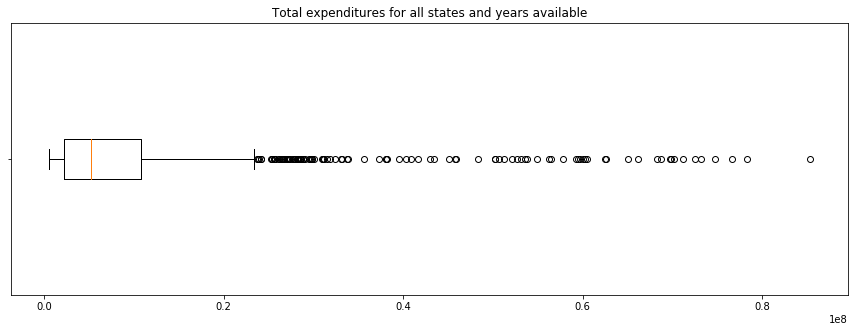

In [290]:
basic_boxplot(used_df['TOTAL_EXPENDITURE'],"Total expenditures for all states and years available") 

In [291]:
used_df['TOTAL_EXPENDITURE'].describe()

count    1.280000e+03
mean     9.196681e+06
std      1.197813e+07
min      4.816650e+05
25%      2.165404e+06
50%      5.234506e+06
75%      1.074519e+07
max      8.532013e+07
Name: TOTAL_EXPENDITURE, dtype: float64

In [257]:
calculate_zscore(used_df['TOTAL_EXPENDITURE'])

The score threshold is: 1
The indices of the outliers:
(array([   4,   32,   56,   85,  108,  137,  150,  161,  190,  213,  241,
        252,  264,  292,  304,  316,  344,  355,  367,  395,  406,  419,
        448,  459,  471,  480,  500,  511,  523,  551,  563,  575,  584,
        603,  614,  626,  631,  635,  652,  654,  660,  666,  678,  683,
        687,  704,  706,  712,  717,  729,  735,  739,  756,  758,  764,
        769,  782,  787,  791,  809,  811,  814,  817,  822,  834,  840,
        844,  861,  863,  866,  869,  874,  889,  895,  899,  916,  918,
        921,  924,  929,  941,  947,  951,  968,  970,  973,  976,  981,
        993,  998, 1002, 1019, 1021, 1024, 1027, 1032, 1044, 1049, 1053,
       1070, 1072, 1075, 1078, 1083, 1095, 1100, 1104, 1121, 1123, 1126,
       1129, 1134, 1146, 1151, 1155, 1172, 1174, 1177, 1180, 1185, 1197,
       1202, 1206, 1223, 1225, 1228, 1231, 1236, 1248, 1253, 1257, 1274,
       1276, 1279]),)
Number of outliers is: 134
The score threshold

(We're going to be asked to modify the TOTAL_REVENUE and TOTAL_EXPENDITURE columns, so I'm calculating this TOTAL_DIFFERENCE value using them _before_ they are altered.)

In [258]:
used_df['TOTAL_DIFFERENCE'] = used_df['TOTAL_REVENUE'] - used_df['TOTAL_EXPENDITURE']

## 2. If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them.

Reminder:
>1. We can drop the outliers from our dataset.
>
>2. We can cap the values of the outliers by assigning them new values.
>
>3. We can transform the outliers into something harmless for our analysis.

1. There are a lot of outliers for both, so dropping them is probably not the best approach.


2. Winsorizing seems reasonable. The outliers are gone, and a box plot of the winsorized values looks a lot like the original box plot in terms of distribution, just without the outliers:


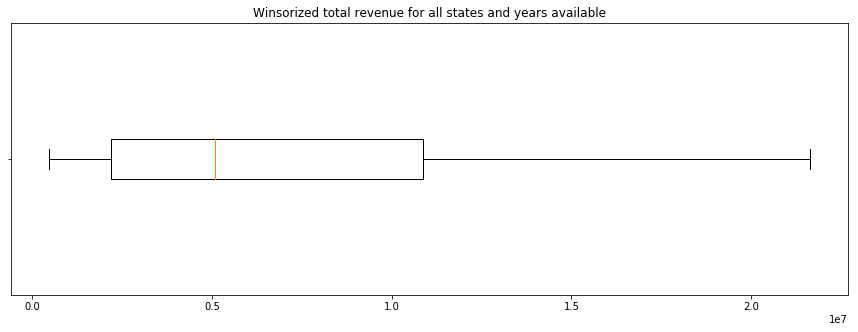

In [259]:
# Winsorizing
winsorized_revenue = winsorize(used_df['TOTAL_REVENUE'], (0, 0.10))
winsorized_expenditures = winsorize(used_df['TOTAL_EXPENDITURE'], (0, 0.10))

basic_boxplot(winsorized_revenue,"Winsorized total revenue for all states and years available")

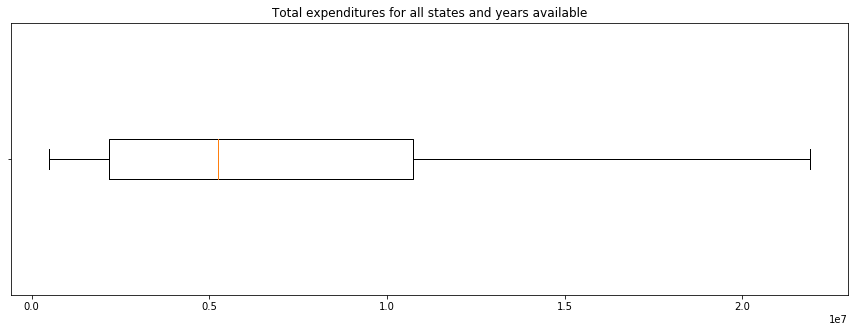

In [260]:
basic_boxplot(winsorized_expenditures,"Total expenditures for all states and years available") 

3. I applied square root and log transformations. The square root transformation still had a lot of outliers, but had a distribution that looked like the original (skewed right).

    The log transformation completely eliminated outliers and left me with an almost-normally distributed box plot, however with a scale that is also completely transformed from the original. How much does this matter for the purposes of analysis?

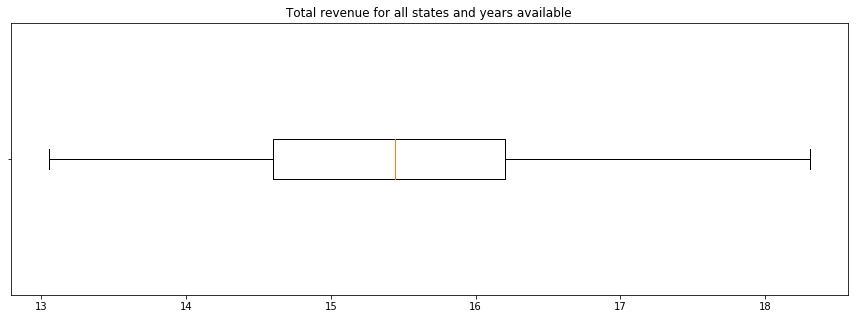

In [261]:
# Log transformation
basic_boxplot(np.log(used_df['TOTAL_REVENUE']),"Total revenue for all states and years available") 

I'm choosing winsorization:

In [262]:
used_df['TOTAL_REVENUE'] = winsorize(used_df['TOTAL_REVENUE'],(0,0.1))
used_df['TOTAL_EXPENDITURE'] = winsorize(used_df['TOTAL_EXPENDITURE'],(0,0.1))

I think we're good now, because at 1.5 standard deviations for both columns, the number of outliers is now zero:

In [263]:
tukeys_method(used_df['TOTAL_REVENUE'])

The score threshold is: 1.0
Number of outliers is: 146
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [264]:
tukeys_method(used_df['TOTAL_EXPENDITURE'])

The score threshold is: 1.0
Number of outliers is: 152
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


## 3. Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

(I create the new feature TOTAL_DIFFERENCE above, before altering the TOTAL_REVENUE and TOTAL_EXPENDITURE columns.)

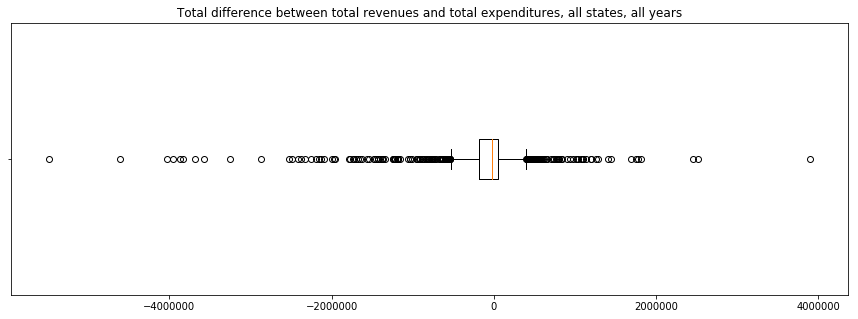

In [265]:
basic_boxplot(used_df['TOTAL_DIFFERENCE'],
              "Total difference between total revenues and total expenditures, all states, all years")

There are all kinds of outliers on both sides of the mean this time.

I can't simply transform these values, at least not with square root or log transformations, because they can't handle negative values. So, I'm choosing winsorization here, setting extreme values to the 10th and 90th percentiles. Then, all of the outliers appear to be handled:

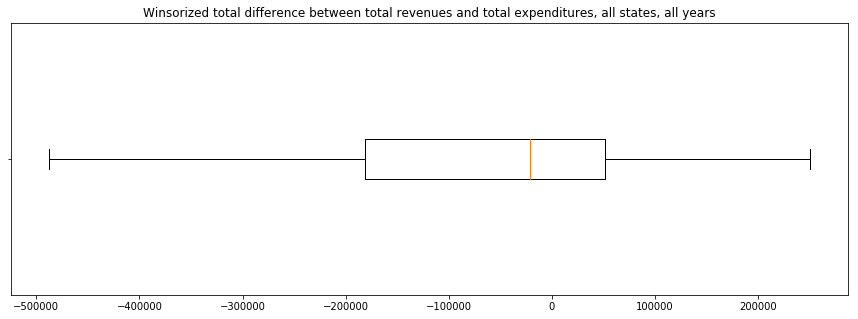

In [266]:
basic_boxplot(winsorize(used_df['TOTAL_DIFFERENCE'], (0.1, 0.1),inplace=True),
              "Winsorized total difference between total revenues and total expenditures, all states, all years")

In [267]:
used_df['TOTAL_DIFFERENCE'].describe()

count      1280.000000
mean     -65660.782031
std      211192.202949
min     -487915.000000
25%     -181685.750000
50%      -21484.000000
75%       51304.250000
max      249996.000000
Name: TOTAL_DIFFERENCE, dtype: float64

## 4. Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

There are still outliers here. 

In [268]:
used_df['TOTAL_DIFF_WINZ'] = used_df['TOTAL_REVENUE'] - used_df['TOTAL_EXPENDITURE']
used_df[['PRIMARY_KEY','TOTAL_DIFF_WINZ']]

,PRIMARY_KEY,TOTAL_DIFF_WINZ
0,1992_ALABAMA,25087.0
1,1992_ALASKA,77103.0
2,1992_ARIZONA,-143501.0
3,1992_ARKANSAS,-31063.0
4,1992_CALIFORNIA,-272297.0
5,1992_COLORADO,-79653.0
6,1992_CONNECTICUT,112964.0
7,1992_DELAWARE,6449.0
8,1992_DISTRICT_OF_COLUMBIA,-33413.0
9,1992_FLORIDA,200657.0


In [269]:
used_df['TOTAL_DIFF_WINZ'].describe()

count    1.280000e+03
mean    -5.560797e+04
std      3.036479e+05
min     -1.650831e+06
25%     -2.219445e+05
50%     -2.843000e+04
75%      3.691850e+04
max      2.520706e+06
Name: TOTAL_DIFF_WINZ, dtype: float64

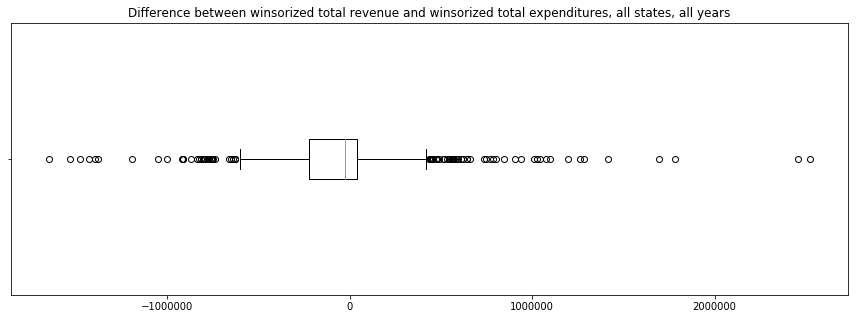

In [270]:
basic_boxplot(used_df['TOTAL_DIFF_WINZ'],
              "Difference between winsorized total revenue and winsorized total expenditures, all states, all years")

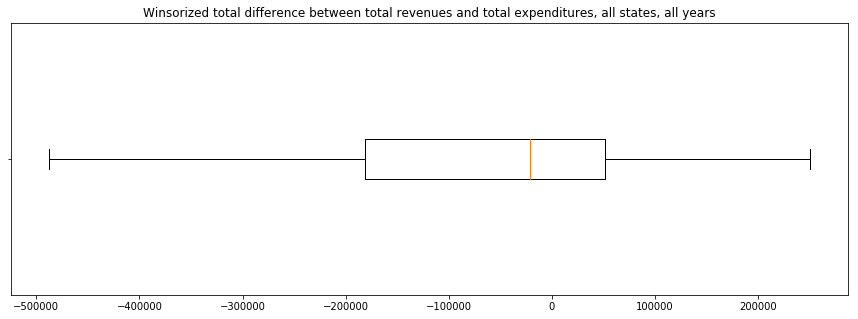

In [271]:
basic_boxplot(used_df['TOTAL_DIFFERENCE'],
              "Winsorized total difference between total revenues and total expenditures, all states, all years")

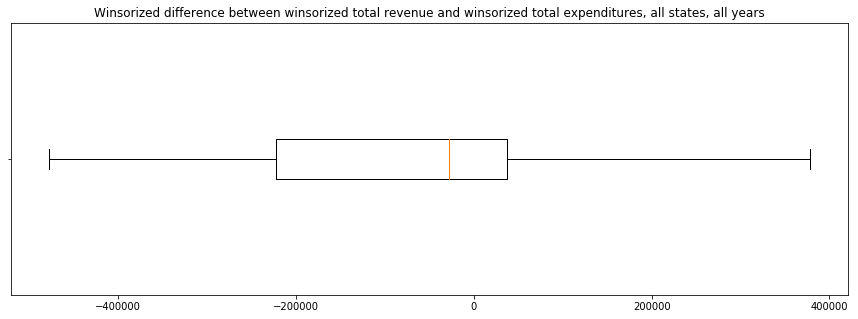

In [272]:
basic_boxplot(winsorize(used_df['TOTAL_DIFF_WINZ'], (0.05,0.05), inplace=True),
              "Winsorized difference between winsorized total revenue and winsorized total expenditures, all states, all years")

After winsorizing:

In [229]:
winz_describe = used_df['TOTAL_DIFF_WINZ'].describe()
winz_describe

count      1280.000000
mean     -60075.889062
std      205073.412959
min     -478143.000000
25%     -221944.500000
50%      -28430.000000
75%       36918.500000
max      377833.000000
Name: TOTAL_DIFF_WINZ, dtype: float64

## 5. Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and the 4th questions. Do you see any differences?

Again, here's how the TOTAL_DIFFERENCE column looks, post-winsorizing. Compare this to the stats for TOTAL_DIFF_WINZ above:

In [230]:
diff_describe = used_df['TOTAL_DIFFERENCE'].describe()
diff_describe

count      1280.000000
mean     -65660.782031
std      211192.202949
min     -487915.000000
25%     -181685.750000
50%      -21484.000000
75%       51304.250000
max      249996.000000
Name: TOTAL_DIFFERENCE, dtype: float64

In [237]:
print("Difference between the two means: {}".format(diff_describe['mean'] - winz_describe['mean']))
print("Difference between the two medians: {}".format(diff_describe['50%'] - winz_describe['50%']))
print("Difference between the two standard deviations: {}".format(diff_describe['std'] - winz_describe['std']))
print("Full range of non-winsorized difference: {}".format(diff_describe['max'] - diff_describe['min']))
print("Full range of winsorized difference: {}".format(winz_describe['max'] - winz_describe['min']))

Difference between the two means: -5584.8929687499985
Difference between the two medians: 6946.0
Difference between the two standard deviations: 6118.789990103454
Full range of non-winsorized difference: 737911.0
Full range of winsorized difference: 855976.0


The means are \\$5000 or so away from each other. The median is similarly shifted, but by slightly more (almost \\$7000).

The standard deviation for the non-winsorized difference is larger, suggesting its values are more widely distributed, though the full range of the winsorized variable is more broad.

## 6. If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

I think in general if we're going to analyze a variable, we should strive to use values that are as close to the original data as is practical.

There didn't seem to be any egregiously bad outliers here--nothing we could attribute to measurement error--just some large values resulting from adding/subtracting large dollar amounts. So I'd say the difference we calculated using the original variables is probably best.